In [65]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import math
import random

plt.rc('font', family='Malgun Gothic')

# 1단계)   ERROR 열에서 평균 / 표준편차를 구한다.
error_df = pd.read_excel("data/실제실험데이터_Error.xlsx", header=1) 

gaussian_mean = {}
gaussian_std = {}

for i in [80,90,100,110,120]: 
    gaussian_mean[i] = error_df['ERROR_'+ str(i)].mean() #평균
    gaussian_std[i] = error_df['ERROR_'+ str(i)].std() #표준편차

# 2단계)   'graph2_논문자체 회귀데이터'에 추가하여 데이터를 생성한다
regression_data = pd.read_excel("data/논문자체 회귀데이터.xlsx", header=1) 

data_80 =  regression_data[['Time_80','Y_80']][:64]
data_90 =  regression_data[['Time_90','Y_90']][:57]
data_100 =  regression_data[['Time_100','Y_100']][:75]
data_110 =  regression_data[['Time_110','Y_110']][:89]
data_120 =  regression_data[['Time_120','Y_120']][:59]

data = data_80
X = 'Time_80'
Y = 'Y_80'

def up_sampling(data):
    df = data
    n=8 #증대 배율
    length = len(data)
    for i in range(n-1):
        l = list(range(length))
        
        df = df.append(df.loc[l], ignore_index = True)
        
        for j in range((i+1)*length,(i+2)*length):
            error = random.gauss(gaussian_mean[80], gaussian_std[80]) #가우시안 분포를 이용한 오차 랜덤 샘플링
            df[Y][j] = df[Y][j] + error
    
    df = df.sort_values(by=X)
    return df
    """
    plt.scatter(df.index, df['Y_80'])
    plt.scatter(df.index, df['fake'])
    plt.xlabel("index")
    plt.ylabel("감자율")
    plt.title("MULTIPLE LINEAR REGRESSION")
    plt.show()
    """
    
up_sampled_data = up_sampling(data)
#up_sampled_data = data
print(up_sampled_data)

        Time_80      Y_80
0        1.0062  0.998023
384      1.0062  0.995477
320      1.0062  0.996914
256      1.0062  1.002106
192      1.0062  0.995219
..          ...       ...
191  10032.0000  0.997897
127  10032.0000  0.997886
63   10032.0000  0.996222
447  10032.0000  0.999609
511  10032.0000  0.996657

[512 rows x 2 columns]


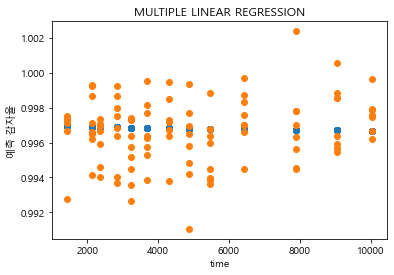

train cv5 R2:[-0.00230016 -0.05870629 -0.07297111  0.00379313 -0.03608811]
train cv5 평균점수 : -0.03325450788562585
test set R2:  -0.0199013947991431
기울기,절편:  [[-0.00014233]] [0.99799948]


In [66]:
# 3단계)   생성한 데이터로 로그회귀 진행
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

x = up_sampled_data[[X]]
y = up_sampled_data[[Y]]

# 데이터셋 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, shuffle=False) #144 예측

#모델 생성
model = LinearRegression()

x_train_log = np.log(x_train) # x값 ln(x)으로 전환
x_test_log = np.log(x_test)
model.fit(x_train_log, y_train) # model fitting

# K-fold model validation
cv_num =5
arr_score = cross_val_score(model,x_train_log,y_train,scoring='r2',cv=cv_num)


#예측 비교
y_predict = model.predict(x_test_log)
plt.scatter(x_test, y_predict)#예측 감자율
plt.scatter(x_test, y_test) #실제 감자율
plt.xlabel("time")
plt.ylabel("예측 감자율")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

print(f"train cv{cv_num} R2:{arr_score}")
print(f'train cv{cv_num} 평균점수 : {arr_score.mean()}')
print("test set R2: ", model.score(x_test_log, y_test))
print("기울기,절편: ", model.coef_,model.intercept_)

In [67]:
# 4단계)   생성한 데이터에 SMOGN 적용하여 로그회귀 진행
import smogn
print(up_sampled_data)
data_smogn = smogn.smoter(
    
    data = up_sampled_data, 
    y = Y
)

dist_matrix:  22%|##############8                                                     | 14/64 [00:00<00:00, 130.81it/s]

        Time_80      Y_80
0        1.0062  0.998023
384      1.0062  0.995477
320      1.0062  0.996914
256      1.0062  1.002106
192      1.0062  0.995219
..          ...       ...
191  10032.0000  0.997897
127  10032.0000  0.997886
63   10032.0000  0.996222
447  10032.0000  0.999609
511  10032.0000  0.996657

[512 rows x 2 columns]


r_index: 100%|#######################################################################| 43/43 [00:00<00:00, 1432.09it/s]


ValueError: oops! synthetic data contains missing values